# Spread skill and optimal initial conditions

In [1]:
import os, torch, nc_time_axis, yaml
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as ctp
from importlib import reload
import hyblim.geoplot as gpl
from hyblim.data import preproc, eof
from hyblim.utils import metric, enso

plt.style.use("../../paper.mplstyle")

def get_model_specs_by_name(experiments, exp_name):
    for exp in experiments:
        if exp['name'] == exp_name:
            return exp 
    return None

# Load list of experiments
with open("experiments.yaml", "r") as f:
    experiments = yaml.safe_load(f)

## Load data

In [2]:
datapaths = {}
datapaths['ssta'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssta_lat-31_33_lon130_290_gr1.0.nc"
datapaths['ssha'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssha_lat-31_33_lon130_290_gr1.0.nc"

da_arr, normalizer = [], {}
for var, path in datapaths.items():
    da = xr.open_dataset(path)[var]
    # Normalize data 
    normalizer_var = preproc.Normalizer()
    da = normalizer_var.fit_transform(da)
    # Store normalizer as an attribute in the Dataarray for the inverse transformation
    da.attrs = normalizer_var.to_dict()
    da_arr.append(da)
    normalizer[var] = normalizer_var

ds = xr.merge(da_arr)

# Apply land sea mask
lsm = xr.open_dataset("../../data/land_sea_mask_common.nc")['lsm']
ds = ds.where(lsm!=1, other=np.nan)

nino_indices = enso.get_nino_indices(ds['ssta'])

In [3]:
# Create PCA
n_eof = [20,10]
eofa_lst = []
for i, var in enumerate(ds.data_vars):
    print(f"Create EOF of {var}!")
    n_components = n_eof[i] if isinstance(n_eof, list) else n_eof 
    eofa = eof.EmpiricalOrthogonalFunctionAnalysis(n_components)
    eofa.fit(
        ds[var].isel(time=slice(None, int(0.8*len(ds['time']))))
    )
    eofa_lst.append(eofa)
combined_eof = eof.CombinedEOF(eofa_lst, vars=list(ds.data_vars))

Create EOF of ssta!
Create EOF of ssha!


In [4]:
# Split in training and test data
train_period = (0, int(0.8*len(ds['time'])))
val_period = (int(0.8*len(ds['time'])), int(0.9*len(ds['time'])))
test_period = ( int(0.9*len(ds['time'])), len(ds['time']) ) 

data = dict(
    train = combined_eof.transform(ds.isel(time=slice(*train_period))),
    val = combined_eof.transform(ds.isel(time=slice(*val_period))),
    test = combined_eof.transform(ds.isel(time=slice(*test_period))),
)

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dat

## Get nino hindcast of LIM

In [5]:
datasplit = 'test'

nino_scores, nino_scores_month = {}, {}
exp = get_model_specs_by_name(experiments, "LIM")
nino_frcst = xr.open_dataset(exp['paths'][0] + '/metrics/nino_frcst_test.nc').transpose('time', 'member', 'lag')
nino_target = xr.open_dataset(exp['paths'][0] + '/metrics/nino_target_test.nc').transpose('time','lag')
nino_scores, nino_scores_month = metric.time_series_score(nino_frcst, nino_target)

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']


## Spread skill ratio

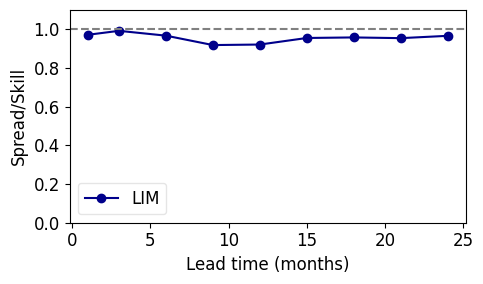

In [6]:
spread_skill = nino_scores['spread_skill']['nino4']
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot(spread_skill.lag, spread_skill.data, 'o-', color='darkblue', label='LIM')
ax.set_ylim(0, 1.1)
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_xlabel('Lead time (months)')
ax.set_ylabel('Spread/Skill')
ax.legend()


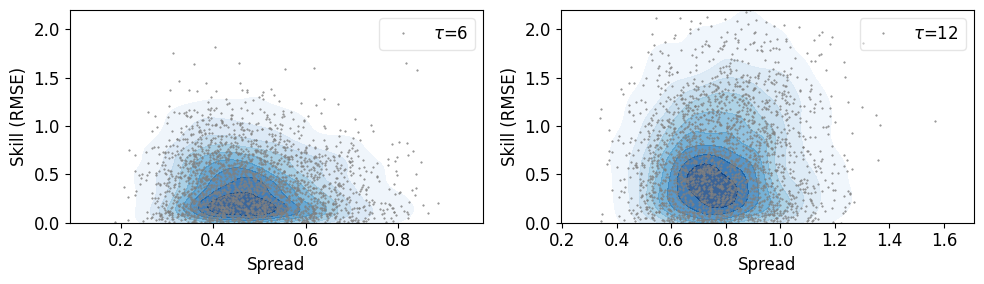

In [7]:
lag_arr = [6, 12]

nrows = len(lag_arr)
fig, axs = plt.subplots(1, nrows, figsize=(5*nrows, 3))
for i, lag in enumerate(lag_arr):
    ax = axs[i]
    spread = nino_frcst['nino4'].sel(lag=lag).std('member')
    skill = np.abs(nino_frcst['nino4'].sel(lag=lag).mean('member') - nino_target['nino4'].sel(lag=lag))

    ax.plot(spread.data, skill.data, '.', markersize=1, color='grey', label=rf"$\tau$={lag}")
    sns.kdeplot(x=spread.data, y=skill.data, ax=ax,
            alpha=0.8, fill=True, cmap='Blues')

    ax.set_xlabel('Spread')
    ax.set_ylabel('Skill (RMSE)')
    ax.set_ylim(0, 2.2)
    ax.legend(loc='upper right')


## Load opitimal initial patterns and their evolution

In [8]:
optimal_init_pc = xr.open_dataarray("../../models/lim/cslim_ssta-ssha/metrics/optimal_init_pc.nc")
optimal_evolved_pc = xr.open_dataarray("../../models/lim/cslim_ssta-ssha/metrics/optimal_evolved_pc.nc")
optimal_init_map = xr.open_dataset("../../models/lim/cslim_ssta-ssha/metrics/optimal_init_map.nc")
optimal_evolved_map = xr.open_dataset("../../models/lim/cslim_ssta-ssha/metrics/optimal_evolved_map.nc")
optimal_init_map = -1* optimal_init_map / optimal_init_map.std()
optimal_evolved_map = -1* optimal_evolved_map / optimal_evolved_map.std()

In [91]:
init_month = 5
lag = 9


# Project optimal initial and evolved patterns onto the data 
idx_init_times = np.argwhere(
    (data['test']['time'].dt.month.values == init_month)
).flatten()[:-lag]
z_init = data['test'].isel(time=idx_init_times)

opt_init = optimal_init_pc.sel(month=init_month, lag=lag)
opt_evolved = optimal_evolved_pc.sel(month=init_month, lag=lag)

proj_data_opt_init = xr.DataArray(data=opt_init.data @ z_init.data.T, 
                                  coords=dict(time=z_init['time'].data))
proj_data_opt_init = np.abs(proj_data_opt_init)

target_dates = np.intersect1d(
    preproc.add_to_cftime(proj_data_opt_init.time.data, lag), nino_frcst.time.data
)
spread = nino_frcst['nino4'].sel(lag=lag, time=target_dates).std('member')
skill = np.abs(
    nino_frcst['nino4'].sel(lag=lag, time=target_dates).mean('member')
    - nino_target['nino4'].sel(lag=lag, time=target_dates)
)

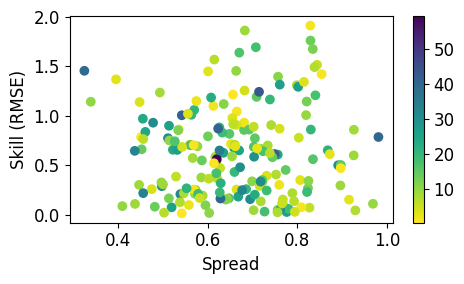

In [92]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
im = ax.scatter(spread.data, skill.data, c=proj_data_opt_init.data[:-1], cmap='viridis_r')
ax.set_xlabel('Spread')
ax.set_ylabel('Skill (RMSE)')
# Add colorbar
cbar = fig.colorbar(im, ax=ax)

# Average values

In [58]:

percentiles = [
    [0, 20],
    [20, 40],
    [40, 60],
    [60, 80],
    [80, 100],
]
lag_arr = [1, 3, 6, 12, 18, 24]


spread, skill = [], []
for lag in lag_arr:
    spread_lag, skill_lag = [], []
    for init_month in range(1, 13):
        # Project optimal initial and evolved patterns onto the data 
        idx_init_times = np.argwhere(
            (data['test']['time'].dt.month.values == init_month)
        ).flatten()[:-lag]
        z_init = data['test'].isel(time=idx_init_times)

        opt_init = optimal_init_pc.sel(month=init_month, lag=lag)
        opt_evolved = optimal_evolved_pc.sel(month=init_month, lag=lag)

        proj_data_opt_init = xr.DataArray(data=opt_init.data @ z_init.data.T, 
                                          coords=dict(time=z_init['time'].data))
        proj_data_opt_init = np.abs(proj_data_opt_init)

        spread_month, skill_month = [], []
        for (pmin, pmax) in percentiles:
            # Select percentilse
            idx_init_dates = np.where(
                (proj_data_opt_init.data >= np.percentile(proj_data_opt_init, pmin))
                & (proj_data_opt_init.data <= np.percentile(proj_data_opt_init, pmax))
            )[0]
            init_dates = proj_data_opt_init['time'].data[idx_init_dates]
            target_dates = np.intersect1d(
                preproc.add_to_cftime(init_dates, lag), nino_frcst.time.data
            )

            print(f"Number of initial dates: {len(init_dates)}")


            spread_month.append(
                nino_frcst['nino4'].sel(lag=lag, time=target_dates).std('member').mean('time')
            )
            skill_month.append(
                np.sqrt(np.square(nino_frcst['nino4'].sel(lag=lag, time=target_dates).mean('member')
                - nino_target['nino4'].sel(lag=lag, time=target_dates, method='nearest')).mean('time'))
            )
        spread_lag.append(
            xr.concat(spread_month, dim=pd.Index([pmin for pmin, pmax in percentiles], name='percentile'))
        )
        skill_lag.append(
            xr.concat(skill_month, dim=pd.Index([pmin for pmin, pmax in percentiles], name='percentile'))
        )
    
    spread.append(
        xr.concat(spread_lag, dim=pd.Index(range(1, 13), name='month'))
    )
    skill.append(
        xr.concat(skill_lag, dim=pd.Index(range(1, 13), name='month'))
    )
spread = xr.concat(spread, dim=pd.Index([1, 3, 6, 12, 18, 24], name='lag'))
skill = xr.concat(skill, dim=pd.Index([1, 3, 6, 12, 18, 24], name='lag'))

Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 40
Number of initial dates: 39
Number of initial dates: 40
Number of initial dates: 40
Number of initial da

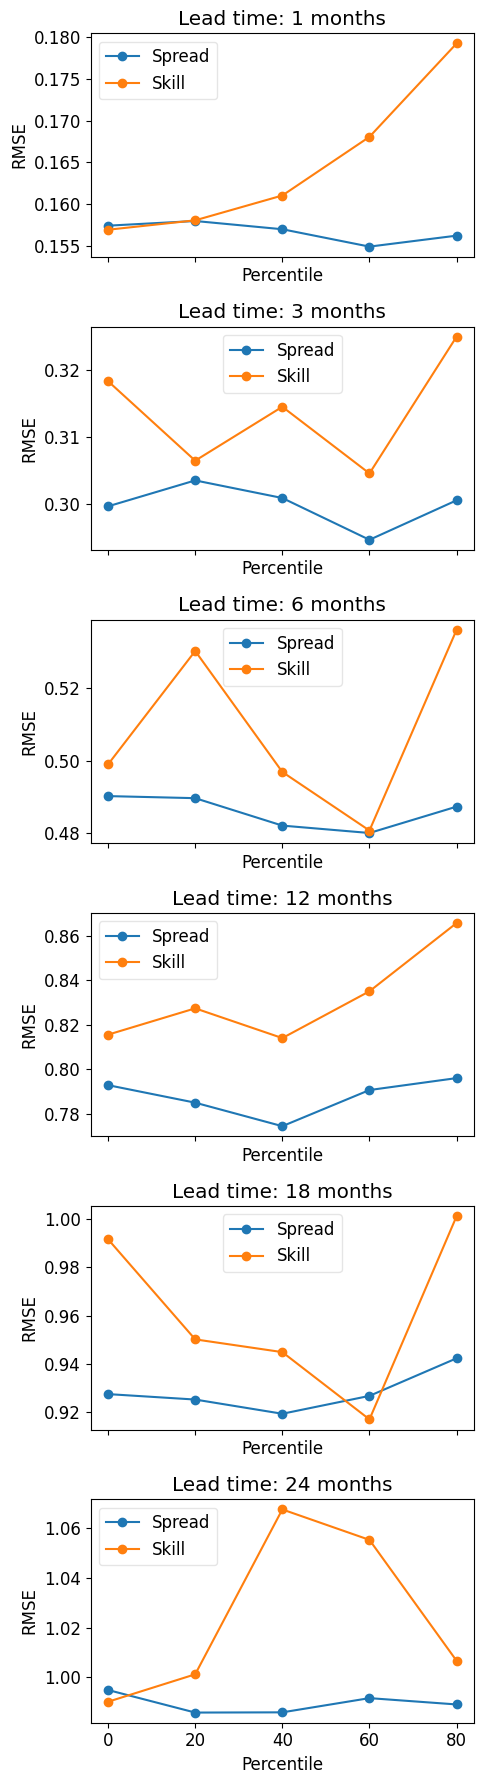

In [67]:
nrows = len(lag_arr)
month = 5

fig, axs = plt.subplots(nrows, 1, figsize=(5, 3*nrows), sharex=True)
for i, lag in enumerate(lag_arr):
    ax = axs[i]
    ax.plot(spread.percentile, spread.sel(lag=lag).mean('month').data, 'o-', label='Spread')
    ax.plot(skill.percentile, skill.sel(lag=lag).mean('month').data, 'o-', label='Skill')
    ax.set_xlabel('Percentile')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.set_title(f"Lead time: {lag} months")
    ax.legend()